In [1]:
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns

Загрузим обучающую выборку

In [2]:
train_df = pd.read_csv("features.zip", index_col = "match_id")

Проверим обучающую выборку на наличие пропусков

In [3]:
print("Следующие признаки имеют пропуски среди своих значений:")
for key in train_df.count()[(train_df.shape[0] - train_df.count())> 0].keys():
    print("*", key)

Следующие признаки имеют пропуски среди своих значений:
* first_blood_time
* first_blood_team
* first_blood_player1
* first_blood_player2
* radiant_bottle_time
* radiant_courier_time
* radiant_flying_courier_time
* radiant_first_ward_time
* dire_bottle_time
* dire_courier_time
* dire_flying_courier_time
* dire_first_ward_time


* **dire_courier_time** - смерть курьера в первые 5 минут игры зависит от времени покупки курьера и навыков игроков.  
* **first_blood_time** - событие первого убийства может произойти после 5 минут от начала игры.

Заменим пропуски в обучающей выборке на нули с помощью функции fillna()

In [4]:
train_df = train_df.fillna(0)

## 

Столбец **radiant_win** является целевой переменной. 

* Значение 1 - победила команда Света
* Значение 0 - победила команда Тьмы

In [5]:
train_df["radiant_win"].value_counts()

1    50414
0    46816
Name: radiant_win, dtype: int64

Удалим признаки, связанные с итогами матча:
 - `duration`: длительность
- Состояние башен и барраков к концу матча (см. описание полей набора данных)
    - `tower_status_radiant`
    - `tower_status_dire`
    - `barracks_status_radiant`
    - `barracks_status_dire`

In [6]:
X_train = train_df.drop(
    [
        "duration",
        "radiant_win",
        "tower_status_radiant",
        "tower_status_dire",
        "barracks_status_radiant",
        "barracks_status_dire",
    ],
    axis=1,
)

y_train = train_df["radiant_win"]


Зафиксируем генератор разбиений для кросс-валидации по 5 блокам (KFold) с перемешиванием объектов (shuffle = True)

In [7]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

## Подход 1: градиентный бустинг "в лоб"

In [8]:
boosting = GradientBoostingClassifier(random_state=42)

Попробуем подобрать оптимальное количество деревьев. Для этого воспользуемся поиском по сетке  (Grid search).

Рассмотрим следующую сетку:
* $ \text{Количество\ деревьев}  \in \{10k \ | k\  \in \{1,2,3,\ldots,50\}\}$


In [9]:
params = {"n_estimators": range(10,51,1)}

In [10]:
grid_search = GridSearchCV(boosting, params, scoring = "roc_auc", cv = cv, n_jobs = -1)    

In [11]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': range(10, 51)}, scoring='roc_auc')

In [12]:
grid_search.best_estimator_

GradientBoostingClassifier(n_estimators=50, random_state=42)

In [13]:
boosting_results = pd.DataFrame(grid_search.cv_results_)

In [14]:
boosting_results["fit_time"] = boosting_results["mean_fit_time"]*cv.n_splits

In [15]:
def plot_cv(cv_results: pd.DataFrame, param: str):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].set_title(f"Зависимость ROC AUC от {param}")
    ax[0].plot(cv_results[f"param_{param}"], cv_results["mean_test_score"])
    ax[0].set_ylabel("Mean test ROC-AUC")
    ax[0].set_xlabel(param)

    ax[1].set_title(f"Зависимость времени обучения от {param}")
    ax[1].plot(cv_results[f"param_{param}"], cv_results["mean_fit_time"])
    ax[1].set_ylabel("Mean fit time")
    ax[1].set_xlabel(param)
    plt.tight_layout()


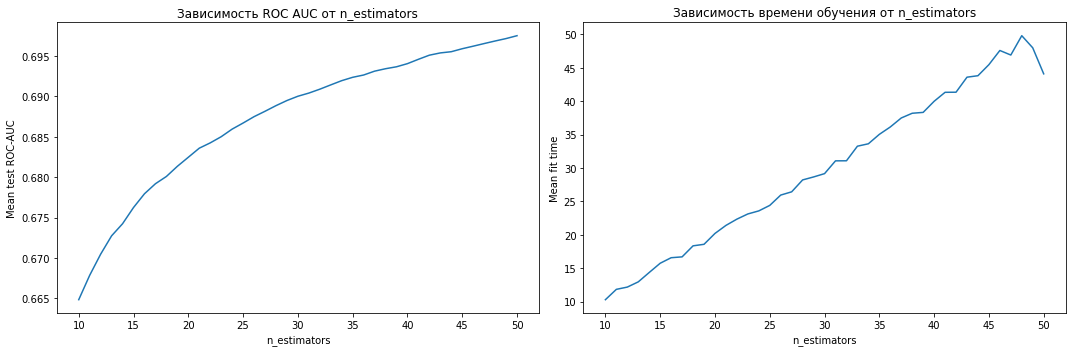

In [16]:
plot_cv(boosting_results, param = "n_estimators")

Кросс-валидация для градиентного бустинга с 30 деревьями проводилась 148 секунд. Значение ROC AUC для данного гиперпараметра равняется 0.690006. Увеличение количества деревьев > 30 приводит к росту ROC AUC, но ухудшает время обучения. Для ускорения обучения можно изменить глубину деревьев, для этого необходимо задать параметр *max_depth*.

In [17]:
boosting_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,fit_time
0,10.297009,0.606067,0.070009,0.021882,10,{'n_estimators': 10},0.663838,0.666355,0.663600,0.665298,0.665162,0.664851,0.001015,41,51.485044
1,11.844545,0.664644,0.062914,0.015995,11,{'n_estimators': 11},0.666163,0.668964,0.666307,0.667726,0.670182,0.667868,0.001544,40,59.222727
2,12.182951,0.856817,0.055395,0.019324,12,{'n_estimators': 12},0.670540,0.671528,0.669602,0.670799,0.669931,0.670480,0.000675,39,60.914756
3,12.964406,0.372972,0.057330,0.015861,13,{'n_estimators': 13},0.672072,0.674465,0.670968,0.672885,0.673358,0.672749,0.001180,38,64.822029
4,14.369068,0.446345,0.053759,0.014650,14,{'n_estimators': 14},0.674336,0.674659,0.671271,0.674736,0.676220,0.674244,0.001622,37,71.845342
5,15.750129,0.415540,0.046789,0.001299,15,{'n_estimators': 15},0.675891,0.676475,0.673836,0.676871,0.678180,0.676250,0.001422,36,78.750647
6,16.576938,0.386354,0.048032,0.002727,16,{'n_estimators': 16},0.678686,0.677843,0.674175,0.679262,0.679781,0.677949,0.001994,35,82.884691
7,16.703995,0.272536,0.048334,0.003364,17,{'n_estimators': 17},0.678593,0.679351,0.676111,0.680413,0.681477,0.679189,0.001822,34,83.519975
8,18.353470,0.560163,0.059354,0.012973,18,{'n_estimators': 18},0.679506,0.680038,0.677161,0.681629,0.682102,0.680087,0.001751,33,91.767351
9,18.583596,0.618642,0.049485,0.003997,19,{'n_estimators': 19},0.680276,0.681582,0.678573,0.682691,0.683591,0.681343,0.001774,32,92.917980


## Подход 2: Логистическая регрессия

Построим модель логистической регрессии и оценим ее по той же схеме, которая использовалась для градиентного бустинга.

In [18]:
logistic_regression = LogisticRegression(penalty="l2", random_state=42)

Так как линейные алгоритмы чувствительны к масштабу признаков выполним стандартизацию данных. 

In [19]:
X_train_scaled = StandardScaler().fit_transform(X_train)

Зададим сетку для подбора параметра **C**

In [20]:
params = {"C": [10.0 ** i for i in range(-4, 4)]}

In [21]:
grid_search = GridSearchCV(logistic_regression, params, scoring = "roc_auc", cv = cv, n_jobs = -1)    

In [22]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                               1000.0]},
             scoring='roc_auc')

In [23]:
grid_search.best_params_

{'C': 0.01}

In [24]:
lr_results = pd.DataFrame(grid_search.cv_results_)
lr_results["fit_time"] = lr_results["mean_fit_time"]*cv.n_splits

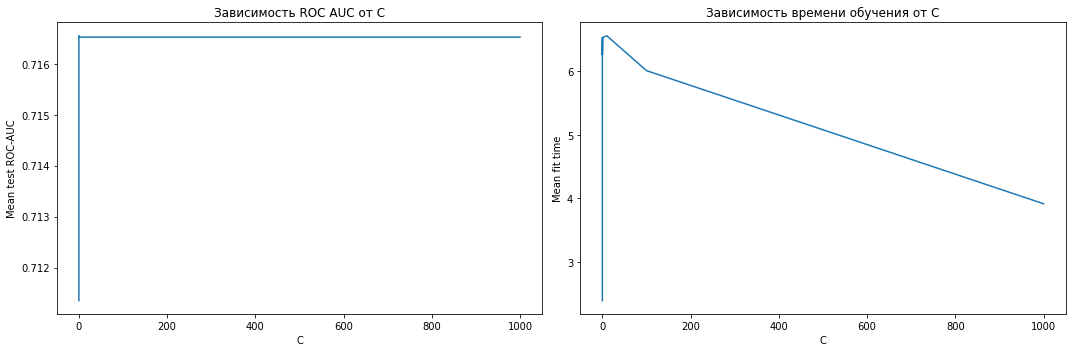

In [25]:
plot_cv(lr_results, param = "C")

In [26]:
lr_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,fit_time
0,2.391300,0.158898,0.047829,0.010273,0.0001,{'C': 0.0001},0.709548,0.710393,0.711695,0.711766,0.713360,0.711352,0.001303,8,11.956501
1,3.900641,0.253385,0.044497,0.014122,0.001,{'C': 0.001},0.714493,0.715771,0.716259,0.716974,0.718318,0.716363,0.001269,7,19.503206
2,6.534794,0.157769,0.051782,0.006665,0.01,{'C': 0.01},0.714645,0.716179,0.716247,0.717350,0.718329,0.716550,0.001238,1,32.673969
3,6.260979,0.686848,0.039409,0.002914,0.1,{'C': 0.1},0.714620,0.716177,0.716191,0.717376,0.718271,0.716527,0.001236,2,31.304893
4,6.533737,0.497949,0.052901,0.006069,1.0,{'C': 1.0},0.714616,0.716172,0.716183,0.717376,0.718264,0.716522,0.001236,3,32.668683
5,6.561277,0.500222,0.043403,0.006639,10.0,{'C': 10.0},0.714616,0.716172,0.716182,0.717376,0.718264,0.716522,0.001236,4,32.806387
6,6.011842,0.438407,0.036644,0.006604,100.0,{'C': 100.0},0.714616,0.716172,0.716182,0.717376,0.718264,0.716522,0.001236,6,30.059209
7,3.915936,0.462206,0.011786,0.002757,1000.0,{'C': 1000.0},0.714616,0.716172,0.716182,0.717376,0.718264,0.716522,0.001236,5,19.579679


Градиентный бустинг при количестве деревьев < 50 показывает худше результаты по ROC AUC и времени обучения, чем модель логистической регрессии (**C** = 0.01). Полученная модель имеет оценку 0.716550.

Исключим из обучающей выборки категориальные признаки *lobby_type* и *r1_hero*, *r2_hero*, ..., *r5_hero*, *d1_hero*, *d2_hero*, ..., *d5_hero*.

In [27]:
X_train_numeric = X_train.drop(
    ["lobby_type"]
    + [f"r{i+1}_hero" for i in range(5)]
    + [f"d{i+1}_hero" for i in range(5)],
    axis=1,
)


In [28]:
X_train_numeric_scaled = StandardScaler().fit_transform(X_train)

Выполним кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации.

In [29]:
grid_search = GridSearchCV(logistic_regression, params, scoring = "roc_auc", cv = cv, n_jobs = -1)    

In [30]:
grid_search.fit(X_train_numeric_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                               1000.0]},
             scoring='roc_auc')

In [31]:
grid_search.best_params_

{'C': 0.01}

In [32]:
lr_results = pd.DataFrame(grid_search.cv_results_)
lr_results["fit_time"] = lr_results["mean_fit_time"]*cv.n_splits

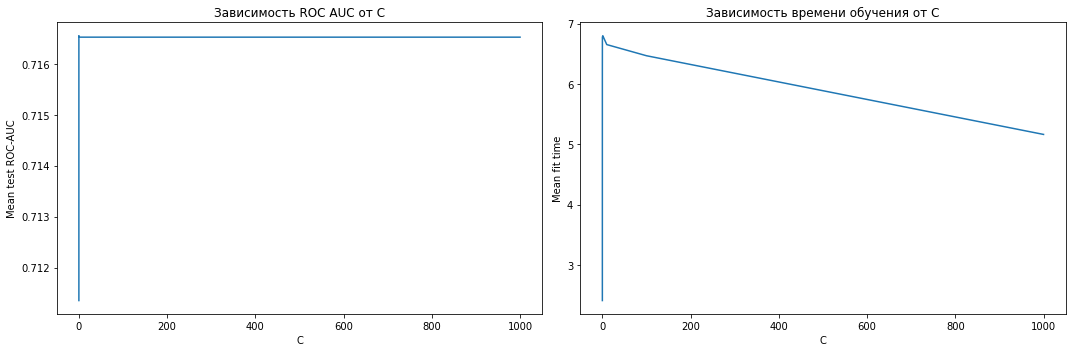

In [33]:
plot_cv(lr_results, param = "C")

In [34]:
lr_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,fit_time
0,2.408234,0.232193,0.041085,0.004024,0.0001,{'C': 0.0001},0.709548,0.710393,0.711695,0.711766,0.713360,0.711352,0.001303,8,12.041171
1,4.314851,0.403971,0.047737,0.011947,0.001,{'C': 0.001},0.714493,0.715771,0.716259,0.716974,0.718318,0.716363,0.001269,7,21.574253
2,6.253395,0.797135,0.049670,0.004928,0.01,{'C': 0.01},0.714645,0.716179,0.716247,0.717350,0.718329,0.716550,0.001238,1,31.266975
3,6.774878,0.807670,0.047228,0.011250,0.1,{'C': 0.1},0.714620,0.716177,0.716191,0.717376,0.718271,0.716527,0.001236,2,33.874390
4,6.798696,0.807559,0.042075,0.011461,1.0,{'C': 1.0},0.714616,0.716172,0.716183,0.717376,0.718264,0.716522,0.001236,3,33.993482
5,6.651983,0.781043,0.044361,0.003703,10.0,{'C': 10.0},0.714616,0.716172,0.716182,0.717376,0.718264,0.716522,0.001236,4,33.259913
6,6.467139,0.654646,0.036201,0.009100,100.0,{'C': 100.0},0.714616,0.716172,0.716182,0.717376,0.718264,0.716522,0.001236,6,32.335697
7,5.162507,1.111405,0.014895,0.004156,1000.0,{'C': 1000.0},0.714616,0.716172,0.716182,0.717376,0.718264,0.716522,0.001236,5,25.812534


Исключение категориальных признаков не привело к улучшению предсказательной силы модели (ROC AUC = 0.716550). Возможно это связано с тем, что не выполнялось кодирование категориальных признаков.

Выясним сколько различных идентификаторов героев существует в данной игре

In [35]:
unique_heroes = np.unique(
    np.hstack(
        (
            X_train[[f"d{i+1}_hero" for i in range(5)]].values.ravel(),
            X_train[[f"r{i+1}_hero" for i in range(5)]].values.ravel(),
        )
    )
)

print("Количество идентификаторов героев в обучающей выборке:", unique_heroes.shape[0])


Количество идентификаторов героев в обучающей выборке: 108


Так как среди выбранных идентификаторов есть номер 112, то, возможно, часть героев отсутствует в обучающей выборке.

In [36]:
N = unique_heroes.max()

Сформируем мешок слов

In [37]:
X_pick = np.zeros((X_train.shape[0], N))

for i, match_id in enumerate(X_train.index):
    for p in range(5):
        X_pick[i, X_train.loc[match_id, "r%d_hero" % (p + 1)] - 1] = 1
        X_pick[i, X_train.loc[match_id, "d%d_hero" % (p + 1)] - 1] = -1

columns = [f"ID_{i+1}" for i in range(N)]

In [38]:
X_heroes = pd.DataFrame(X_pick, columns=columns)
X_train_numeric_wh = pd.concat([X_train_numeric.reset_index(), X_heroes], axis = 1)

In [39]:
X_train_numeric_wh

,match_id,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,...,ID_103,ID_104,ID_105,ID_106,ID_107,ID_108,ID_109,ID_110,ID_111,ID_112
0,0,1430198770,5,2098,1489,20,0,0,7,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1430220345,4,1188,1033,9,0,1,12,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1430227081,4,1319,1270,22,0,0,12,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1430263531,4,1779,1056,14,0,0,5,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1430282290,4,1431,1090,8,1,0,8,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97225,114402,1450265551,4,1706,1198,17,0,1,8,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97226,114403,1450277704,4,1793,1416,17,0,1,5,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
97227,114404,1450291848,4,1399,540,1,0,0,5,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
97228,114405,1450292986,3,1135,766,6,0,2,6,5,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
X_train_numeric_wh_scaled = StandardScaler().fit_transform(X_train_numeric_wh)

Построим модель логистической регрессии с категориальными признаками, закодированными с помощью мешка слов.

In [41]:
grid_search = GridSearchCV(logistic_regression, params, scoring = "roc_auc", cv = cv, n_jobs = -1)    

In [42]:
grid_search.fit(X_train_numeric_wh_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                               1000.0]},
             scoring='roc_auc')

In [43]:
lr_results = pd.DataFrame(grid_search.cv_results_)
lr_results["fit_time"] = lr_results["mean_fit_time"]*cv.n_splits

Лучшая модель получилась при C = 0.01

In [44]:
grid_search.best_params_

{'C': 0.01}

In [45]:
lr_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,fit_time
0,3.983172,0.253014,0.077732,0.017321,0.0001,{'C': 0.0001},0.740116,0.742063,0.741494,0.746305,0.744005,0.742797,0.002153,8,19.915858
1,7.400904,0.683700,0.094497,0.031672,0.001,{'C': 0.001},0.748993,0.752374,0.749493,0.755826,0.751678,0.751673,0.002436,7,37.004522
2,12.114814,0.861916,0.091926,0.011954,0.01,{'C': 0.01},0.749479,0.753225,0.749575,0.756146,0.751661,0.752017,0.002492,1,60.574072
3,13.706142,0.951706,0.078379,0.012325,0.1,{'C': 0.1},0.749488,0.753234,0.749522,0.756089,0.751579,0.751983,0.002485,2,68.530711
4,12.985571,0.580604,0.085721,0.008686,1.0,{'C': 1.0},0.749488,0.753235,0.749518,0.756079,0.751572,0.751978,0.002482,3,64.927855
5,13.510489,0.987290,0.078049,0.006466,10.0,{'C': 10.0},0.749489,0.753235,0.749516,0.756078,0.751571,0.751978,0.002482,4,67.552446
6,13.375827,0.753680,0.055176,0.013863,100.0,{'C': 100.0},0.749489,0.753235,0.749516,0.756077,0.751571,0.751978,0.002482,6,66.879135
7,9.313082,1.292974,0.022999,0.007668,1000.0,{'C': 1000.0},0.749489,0.753235,0.749516,0.756077,0.751571,0.751978,0.002482,5,46.565408


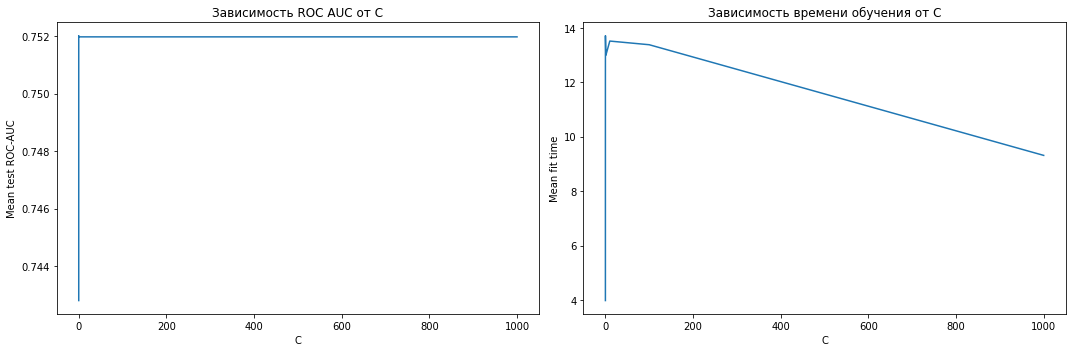

In [46]:
plot_cv(lr_results, param = "C")

Применение мешка слов улучшило ROC AUC до 0.752017.

In [47]:
best_estimator = grid_search.best_estimator_

Построим предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей

In [48]:
test = pd.read_csv("features_test.zip", index_col="match_id")
X_test = test.fillna(0)

In [49]:
X_test_numeric = X_test.drop(
    ["lobby_type"]
    + [f"r{i+1}_hero" for i in range(5)]
    + [f"d{i+1}_hero" for i in range(5)],
    axis=1,
)


In [50]:
X_pick = np.zeros((X_test.shape[0], N))

for i, match_id in enumerate(X_test.index):
    for p in range(5):
        X_pick[i, X_test.loc[match_id, "r%d_hero" % (p + 1)] - 1] = 1
        X_pick[i, X_test.loc[match_id, "d%d_hero" % (p + 1)] - 1] = -1

columns = [f"ID_{i+1}" for i in range(N)]

In [51]:
X_heroes = pd.DataFrame(X_pick, columns=columns)
X_test_numeric_wh = pd.concat([X_test_numeric.reset_index(), X_heroes], axis=1)


In [52]:
X_test_numeric_wh_scaled = StandardScaler().fit_transform(X_test_numeric_wh)

In [53]:
probabilities = best_estimator.predict_proba(X_test_numeric_wh_scaled)[:,1]


<AxesSubplot:ylabel='Count'>

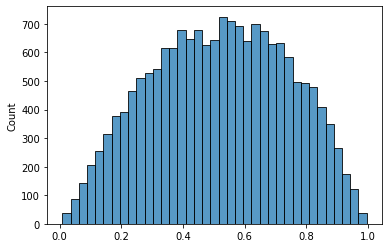

In [54]:
sns.histplot(probabilities)

In [55]:
print("Минимальное значение прогноза на тестовой выборке:", probabilities.min())
print("Максимальное значение прогноза на тестовой выборке:", probabilities.max())

Минимальное значение прогноза на тестовой выборке: 0.008615287707374873
Максимальное значение прогноза на тестовой выборке: 0.9964051844033889
